In [1]:
import pandas as pd
from patsy import dmatrices
import matplotlib.pyplot as plt
import math as m
import numpy as np
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
sns.set()

In [2]:
def growth_rate_to_doubling_time(growth_rates):
    return np.sign(growth_rates) * (np.log(2) / (np.sign(growth_rates) * growth_rates))

def doubling_time_to_growth_rate(doubling_times):
    return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))

In [3]:
data = pd.read_excel("../../Data/Simulation Results/UK Model/no_time_limits.xlsx", index_col = 0)
days_simulated = 25

In [4]:
data

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,prob_has_trace_app,backwards_trace,0,1,2,...,15,16,17,18,19,20,21,22,23,24
0,0.222421,0.2,0.874731,2.324604,0.071752,0.106806,True,5000,5022,5343,...,103541,125347,151238,181977,218208,260691,310355,369057,437527,517268
1,0.215233,0.1,0.864710,2.471751,0.066769,0.217585,True,5000,5017,5350,...,106971,130812,159445,194107,235659,285304,344904,415680,501135,602653
2,0.215233,0.1,0.830757,2.188997,0.352741,0.416629,True,5000,5012,5261,...,53289,61356,70436,80667,91990,104624,118928,134580,152041,171362
3,0.243986,0.5,0.849321,2.344838,0.400630,0.169612,True,5000,5009,5258,...,44151,49018,54095,59429,65094,70934,77187,83350,89974,96848
4,0.229609,0.3,0.791246,2.000628,0.084615,0.152408,True,5000,5021,5354,...,98646,117919,140858,167491,198148,233408,275126,323061,378233,442117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.222421,0.2,0.717091,2.217652,0.165482,0.255358,True,5000,5012,5266,...,83783,100001,119052,141275,166996,197296,232554,273312,320583,375278
96,0.236797,0.4,0.765937,2.414052,0.629537,0.098675,True,5000,5009,5168,...,23851,25461,27109,28685,30241,31734,33233,34740,36262,37704
97,0.215233,0.1,0.906219,2.442269,0.264715,0.074344,True,5000,5011,5268,...,65554,77192,90525,105735,123261,143528,166620,192923,222513,256669
98,0.229609,0.3,0.891559,2.108665,0.275558,0.019658,True,5000,5015,5262,...,59810,68693,78695,89829,101863,115021,129420,145448,162755,181605


In [5]:
infection_counts = [str(i) for i in range(days_simulated)]
infection_counts = data[infection_counts]

Text(0.5, 1.0, 'Total Infected')

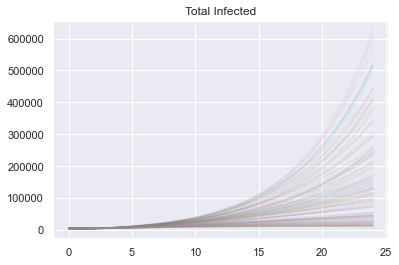

In [6]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_], alpha = 0.1)
plt.title("Total Infected")

Text(0.5, 1.0, '$log_2$(Total Infected)')

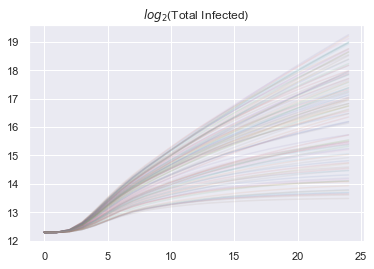

In [7]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].apply(lambda x: np.log2(x)), alpha = 0.1)
plt.title("$log_2$(Total Infected)")

Text(0.5, 1.0, 'Infection Incidence')

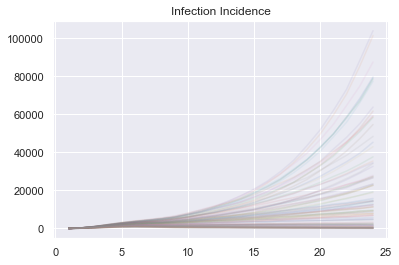

In [8]:
for _ in range(data.shape[0]):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.1)
plt.title("Infection Incidence")

Text(0.5, 1.0, 'Infection Incidence (10 epidemics)')

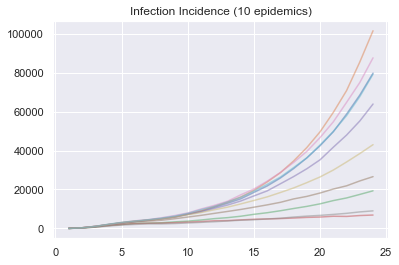

In [9]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1), alpha = 0.5)
plt.title("Infection Incidence (10 epidemics)")

Text(0.5, 1.0, '$Log_e$(Case Incidence) (14 epidemics)')

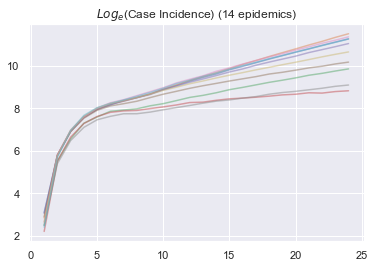

In [10]:
for _ in range(10):
    plt.plot(range(days_simulated), infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x)), alpha = 0.5)
plt.title("$Log_e$(Case Incidence) (14 epidemics)")
#plt.savefig("Figures/Log_case_incidence.png")

We can see the variance begins to increase for the exponentially decaying epidemcis as they near 0. In order to get good estimation for the epidemics, we icnrease the starting number of infections. In this experiment, we start with 5000 infected, let the process run for 10 days, and then estimated the growth rate using days 10-30.

In [11]:
log_diff = infection_counts.iloc[_].diff(1).apply(lambda x: np.log(x))

data_set_up = {
    "log_case_incidence": log_diff[10:days_simulated],
    "time": list(range(10, days_simulated))
}
dataframe = pd.DataFrame(data_set_up)

C:\Users\mfyles\OneDrive - The Alan Turing Institute\Documents\household-contact-tracing\tracing\lib\site-packages\scipy\stats\stats.py:1534: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


                            OLS Regression Results                            
Dep. Variable:     log_case_incidence   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.185e+04
Date:                Tue, 23 Jun 2020   Prob (F-statistic):           1.24e-20
Time:                        11:16:06   Log-Likelihood:                 35.007
No. Observations:                  15   AIC:                            -66.01
Df Residuals:                      13   BIC:                            -64.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3749      0.026    279.271      0.0

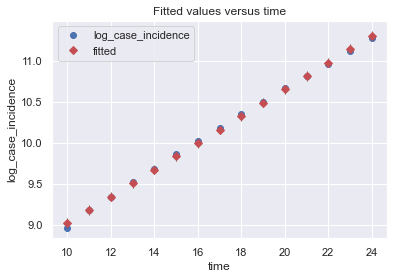

In [12]:
y, X = dmatrices('log_case_incidence ~ time', 
                 data = dataframe)
model = sma.OLS(y, X)
res = model.fit()
print(res.summary())
fig = sm.graphics.regressionplots.plot_fit(res, 1)
print(f"doublign time = {m.log(2)/res.params[1]}")

In [13]:
data_subset = infection_counts

In [14]:
growth_rates = []
for _ in range(data_subset.shape[0]):
    print(f"current fit; {_}", end = "\r")
    
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    data_set_up = {
        "log_case_incidence": log_diff[10:25],
        "time": list(range(10, 25))
    }
    dataframe = pd.DataFrame(data_set_up)
    dataframe = pd.DataFrame(data_set_up)
    
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

In [15]:
x = pd.Series(growth_rates) # 200 values
#x = x[x.between(x.quantile(.05), x.quantile(.95))] # without outliers

Text(0.5, 1.0, 'Distribution of Growth Rates')

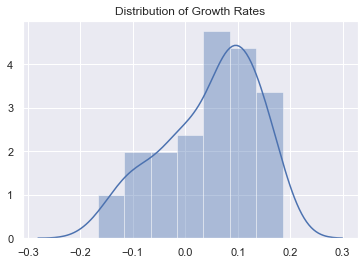

In [16]:
sns.distplot(x)
plt.title("Distribution of Growth Rates")

In [17]:
data_pars = data[data.columns[0:9]]
growth_rate_series = pd.Series(growth_rates)
data_pars["growth_rate"] = growth_rate_series

<ipython-input-17-4e3da95ff708>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pars["growth_rate"] = growth_rate_series


In [18]:
data_pars

,hazard_rate_scale,infection_reporting_prob,contact_tracing_success_prob,contact_trace_delay_par,global_contact_reduction,prob_has_trace_app,backwards_trace,0,1,growth_rate
0,0.222421,0.2,0.874731,2.324604,0.071752,0.106806,True,5000,5022,0.169796
1,0.215233,0.1,0.864710,2.471751,0.066769,0.217585,True,5000,5017,0.185950
2,0.215233,0.1,0.830757,2.188997,0.352741,0.416629,True,5000,5012,0.116025
3,0.243986,0.5,0.849321,2.344838,0.400630,0.169612,True,5000,5009,0.050577
4,0.229609,0.3,0.791246,2.000628,0.084615,0.152408,True,5000,5021,0.154337
...,...,...,...,...,...,...,...,...,...,...
95,0.222421,0.2,0.717091,2.217652,0.165482,0.255358,True,5000,5012,0.156922
96,0.236797,0.4,0.765937,2.414052,0.629537,0.098675,True,5000,5009,-0.008224
97,0.215233,0.1,0.906219,2.442269,0.264715,0.074344,True,5000,5011,0.141452
98,0.229609,0.3,0.891559,2.108665,0.275558,0.019658,True,5000,5015,0.102051


                            OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     3816.
Date:                Tue, 23 Jun 2020   Prob (F-statistic):          2.05e-110
Time:                        11:16:11   Log-Likelihood:                 383.37
No. Observations:                 100   AIC:                            -750.7
Df Residuals:                      92   BIC:                            -729.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

<ipython-input-2-e3933c76672f>:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))
<ipython-input-2-e3933c76672f>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))


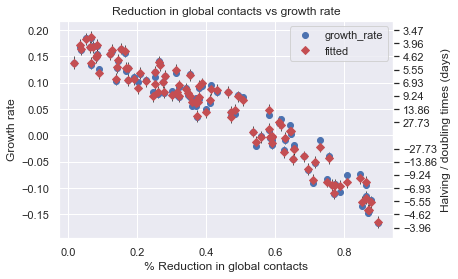

In [19]:
y, X = dmatrices('growth_rate ~ global_contact_reduction + I(global_contact_reduction**2) + I(global_contact_reduction**3) + I(prob_has_trace_app**2) +  contact_tracing_success_prob + contact_trace_delay_par + contact_trace_delay_par + infection_reporting_prob', 
                 data = data_pars)
model_2 = sma.OLS(y, X)
res = model_2.fit()
print(res.summary())

fig, ax = plt.subplots()

plot = sm.graphics.regressionplots.plot_fit(res, "global_contact_reduction", ax = ax)

y_vals = np.linspace(-0.175, 0.25, 18)
y_vals = np.concatenate((y_vals[:7], y_vals[8:]))

ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)

plt.xlabel("% Reduction in global contacts")
plt.ylabel("Growth rate")
plt.title("Reduction in global contacts vs growth rate")
ax2.set_ylabel("Halving / doubling times (days)")
plt.savefig("../../Figures/Simulation - no test delay/growth_rate_global_contacts.png", bbox_inches = 'tight')
plt.savefig("../../Figures/Simulation - no test delay/growth_rate_global_contacts.svg", bbox_inches = 'tight')

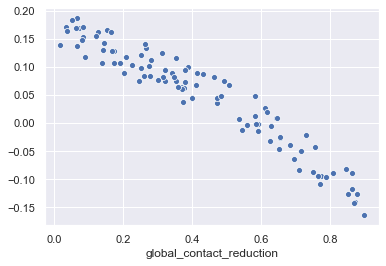

In [20]:
sns.scatterplot(data_pars["global_contact_reduction"], res.fittedvalues)

## Residuals vs Fitted Value

There doesn't appear to be any systematic deviation from our predicted value

Text(0, 0.5, 'Residual')

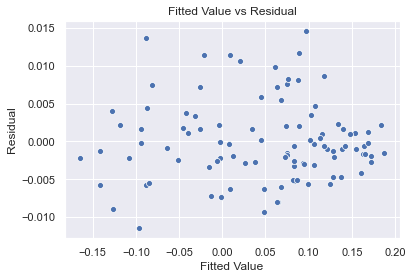

In [21]:
sns.scatterplot(res.fittedvalues, res.resid)
plt.title("Fitted Value vs Residual")
plt.xlabel("Fitted Value")
plt.ylabel("Residual")

## Residual Distribution

Text(0.5, 1.0, 'Distribution of the residuals')

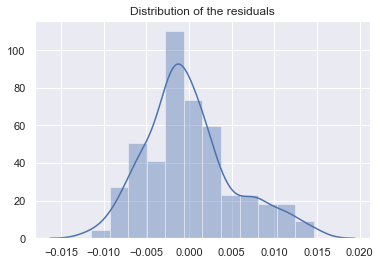

In [22]:
sns.distplot(res.resid)
plt.title("Distribution of the residuals")

Sort of normally distributed

## Comparison to reference distributions

In [23]:
reference_coefs = pd.read_excel("../../Data/Reference/OLS_coefficients.xlsx", index_col = 0)
reference_coefs

,intercept,coef_contact_reduction,coef_contact_reduction**2,coef_contact_reduction**2.1
0,0.22251,-0.255676,0.123382,-0.286964


In [24]:
c = reference_coefs["intercept"].loc[0]
beta_0 = reference_coefs["coef_contact_reduction"].loc[0]
beta_1 = reference_coefs["coef_contact_reduction**2"].loc[0]
beta_2 = reference_coefs["coef_contact_reduction**2.1"].loc[0]
x = np.linspace(0, 0.9)
y = c + beta_0*x + beta_1*x**2 + beta_2*x**3

<ipython-input-2-e3933c76672f>:5: RuntimeWarning: divide by zero encountered in true_divide
  return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))
<ipython-input-2-e3933c76672f>:5: RuntimeWarning: invalid value encountered in multiply
  return np.sign(doubling_times) * ( np.log(2) / (np.sign(doubling_times) * doubling_times))


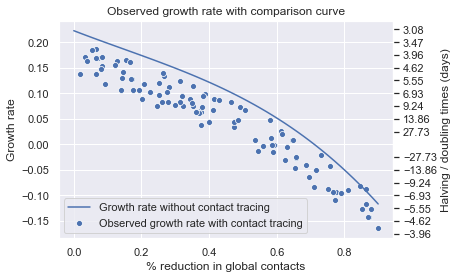

In [25]:

fig, ax = plt.subplots()

sns.scatterplot(data_pars["global_contact_reduction"], res.fittedvalues)
plt.plot(x, y)

y_vals = np.linspace(-0.175, 0.25, 18)
y_vals = np.concatenate((y_vals[:7], y_vals[8:]))


ax2 = ax.secondary_yaxis("right",
                         functions=(growth_rate_to_doubling_time,
                                    doubling_time_to_growth_rate))
ax2.set_ticks(growth_rate_to_doubling_time(y_vals), minor = False)


plt.legend(("Growth rate without contact tracing", "Observed growth rate with contact tracing"))
plt.title("Observed growth rate with comparison curve")
plt.ylabel("Growth rate")
plt.xlabel("% reduction in global contacts")
ax2.set_ylabel("Halving / doubling times (days)")
plt.savefig("../../Figures/Simulation - no test delay/growth_rate_comparison.svg", bbox_inches = 'tight')
plt.savefig("../../Figures/Simulation - no test delay/growth_rate_comparison.png", bbox_inches = 'tight')